In [1]:
import rootpath
import sys
import os
sys.path.append(rootpath.detect())

import matplotlib.pyplot as plt
from matplotlib.cm import Purples
import matplotlib as mpl
import numpy as np
from testsuite.surrogates import GP, MultiSurrogate
from testsuite.utilities import Pareto_split

In [2]:
# establish up data paths
try: 
    get_ipython().__class__.__name__
    script_dir = os.path.dirname(os.path.realpath(__file__))
except:
     script_dir = './'
if not os.path.isdir('./figures'):
    os.makedirs("./figures")

In [3]:
def save_fig(fig, name=None):
    figname_stub = script_dir.split('/')[-1]
    if name is None:
        filename = figname_stub+"_"+fig.get_title()
    else:
        filename = figname_stub+"_"+name
    
    savedirs = [os.path.join(script_dir, "figures/"),
                "/home/finley/phd/papers/SAF-driven-EMO/figures/"]
    for d in savedirs:
        fig.savefig(os.path.join(d, filename+".png"), dpi=300, facecolor=None, edgecolor=None,
        orientation='portrait', pad_inches=0.12)
        fig.savefig(os.path.join(d, filename+".pdf"), bbox_inches = 'tight', pad_inches = 0, dpi=300, facecolor=None, edgecolor=None,
        orientation='portrait')
    

In [4]:
import matplotlib
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import MaxNLocator


matplotlib.rcParams['mathtext.fontset'] = 'stix';
matplotlib.rcParams['font.family'] = 'STIXGeneral';
matplotlib.rcParams['font.size'] = 15 ;
matplotlib.rcParams['legend.fontsize'] = 15
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
seed = 1
INVERT = True
plt.rcParams['image.cmap'] = 'viridis'

In [7]:
def image_infill(opt, front_value = 0., n_contours=20, uncertainty=0.1):
    #figure_properties
    fig = plt.figure(figsize=[9,7])
    ax = fig.gca()
    l_lims = opt.apply_weighting(np.array([[0, 0]]))
    u_lims = opt.apply_weighting(np.array([[1.5, 1.5]]))
    ax.set_xlim([0., 1.5])
    ax.set_ylim([0., 1.5])
    
    # compute infill
    M, N = 200, 200
    x = np.linspace(0., 1.5, M)
    y = np.linspace(0., 1.5, N)
    xx, yy = np.meshgrid(x, y)
    xy = np.vstack((xx.flat, yy.flat)).T
    xyw = opt.apply_weighting(xy)
    zz = np.array([opt._scalarise_y(xyi, np.ones_like(xyi)*uncertainty*opt.obj_weights, invert=False) for xyi in xyw])
    zz = zz.reshape(N,M)
    
    #image infill
    pcol = ax.pcolor(xx, yy, zz)
    levels = np.linspace(zz.min(), zz.max(), n_contours+2)[1:-1]
    ax.contour(xx, yy, zz, colors="white", levels=levels)
    if front_value is not None:
        ax.contour(xx, yy, zz, colors="C3", levels=[front_value])
        front_legend = plt.Line2D([0], [0], c="C3")
    
    # scatter samples
    ax.scatter(opt.d[:,0], opt.d[:,1], facecolors='none', edgecolors="C3", linewidth=2., label="dominated samples")
    ax.scatter(opt.p[:,0], opt.p[:,1], c="C3", label="non-dominated samples")
    fig.colorbar(pcol)
    handles, labels = ax.get_legend_handles_labels()
    if front_value is not None:
        handles.append(front_legend)
        labels.append("{}".format(front_value))
    ax.legend(handles, labels)
    
    return fig

 <ipython-input-7-a5929b15f1fe>:21: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0, 0.5, '$f_2$')

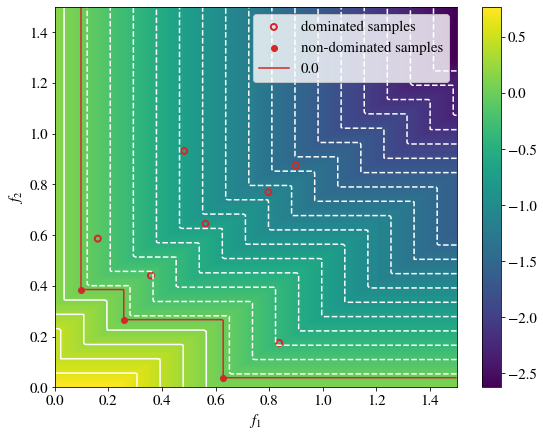

In [8]:
from testsuite.optimisers import Saf

saf_opt = Saf(objective_function=lambda x: x[0:2], ei=False,  limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=MultiSurrogate(GP), n_initial=10, seed=seed)
# saf_opt.obj_weights = np.ones_like(saf_opt.obj_weights)
fig_saf = image_infill(saf_opt)
# fig_saf.axes[0].set_title("saf: $\mu$");

fig_saf.gca().set_xlabel("$f_1$")
fig_saf.gca().set_ylabel("$f_2$")
# fig_saf.axes[0].scatter((saf_opt.y*saf_opt.obj_weights)[:,0], (saf_opt.y*saf_opt.obj_weights)[:,1], c="magenta")

In [8]:
save_fig(fig_saf, name="objective_space_SAF_mu")

 <ipython-input-6-a5929b15f1fe>:21: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
 <ipython-input-6-a5929b15f1fe>:25: UserWarning:No contour levels were found within the data range.


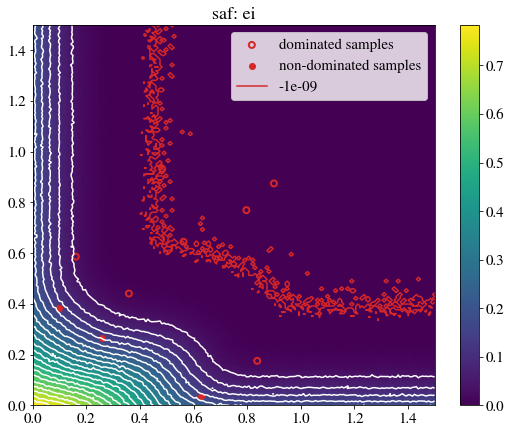

In [9]:
safei_opt = Saf(objective_function=lambda x: x[0:2], ei=True,  limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=MultiSurrogate(GP), n_initial=10, seed=seed)
# safei_opt.obj_weights = np.ones_like(safei_opt.obj_weights)
front_v = -1e-9 if INVERT else 1e-9
fig_safei = image_infill(safei_opt, front_value=front_v)
fig_safei.axes[0].set_title("saf: ei");

 <ipython-input-7-a5929b15f1fe>:21: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


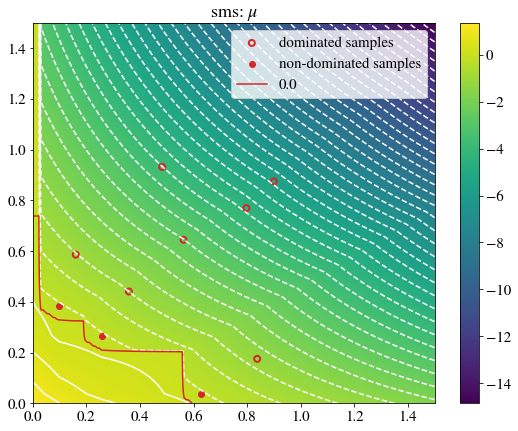

In [9]:
from testsuite.optimisers import SmsEgo

smsego_opt = SmsEgo(objective_function=lambda x: x[0:2], limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=MultiSurrogate(GP), n_initial=10, seed=seed)

# smsego_opt.obj_weights = np.ones_like(smsego_opt.obj_weights)
# smsego_opt.obj_offset = np.zeros_like(smsego_opt.obj_offset)
fig_smsego = image_infill(smsego_opt, n_contours=40)
fig_smsego.axes[0].set_title("sms: $\mu$");

 <ipython-input-6-a5929b15f1fe>:21: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


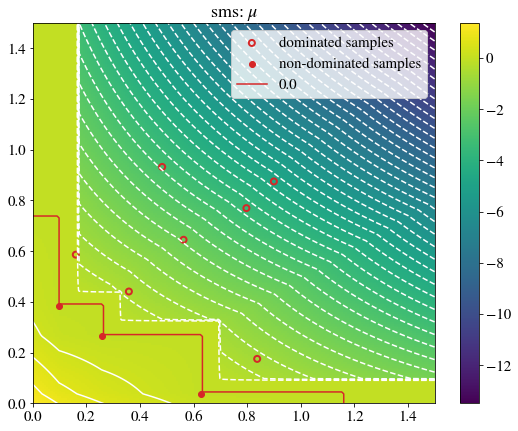

In [11]:
from testsuite.optimisers import SmsEgo

smsego_opt = SmsEgo(objective_function=lambda x: x[0:2], limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=MultiSurrogate(GP), n_initial=10, seed=seed)

# smsego_opt.obj_weights = np.ones_like(smsego_opt.obj_weights)
# smsego_opt.obj_offset = np.zeros_like(smsego_opt.obj_offset)
fig_smsego = image_infill(smsego_opt, n_contours=40)
fig_smsego.axes[0].set_title("sms: $\mu$");

 <ipython-input-7-e87fab732c3b>:21: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


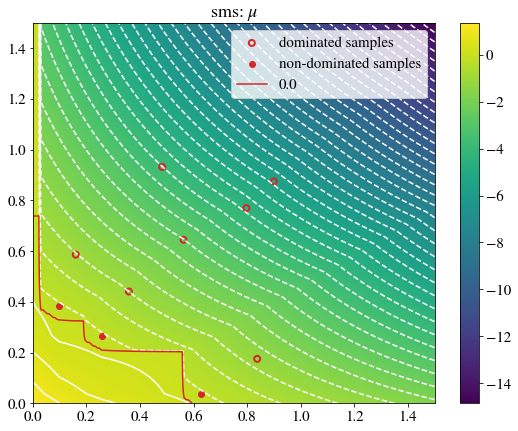

In [10]:
from testsuite.optimisers import SmsEgo

smsego_opt = SmsEgo(objective_function=lambda x: x[0:2], limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=MultiSurrogate(GP), n_initial=10, seed=seed)
smsego_opt.ref_vector= np.array([0.8, 0.8])
# smsego_opt.obj_weights = np.ones_like(smsego_opt.obj_weights)
# smsego_opt.obj_offset = np.zeros_like(smsego_opt.obj_offset)
fig_smsego = image_infill(smsego_opt, n_contours=40)
fig_smsego.axes[0].set_title("sms: $\mu$");

In [ ]:
from testsuite.optimisers import SmsEgo

smsego_opt = SmsEgo(objective_function=lambda x: x[0:2], limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=MultiSurrogate(GP), n_initial=10, seed=seed)

# smsego_opt.obj_weights = np.ones_like(smsego_opt.obj_weights)
# smsego_opt.obj_offset = np.zeros_like(smsego_opt.obj_offset)
fig_smsego = image_infill(smsego_opt, n_contours=40)
fig_smsego.axes[0].set_title("sms: $\mu$");

 <ipython-input-7-e87fab732c3b>:21: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


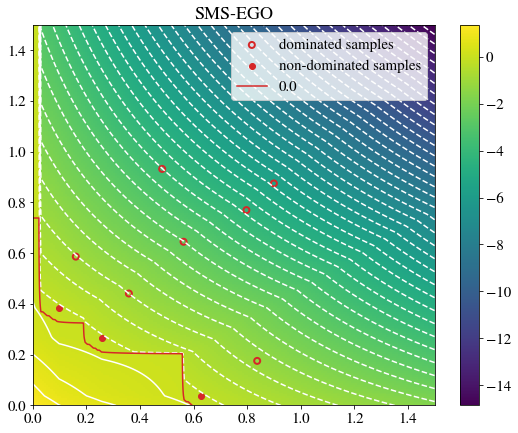

In [17]:
from testsuite.optimisers import SmsEgo

smsego_opt = SmsEgo(objective_function=lambda x: x[0:2], limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=MultiSurrogate(GP), n_initial=10, seed=seed)

# smsego_opt.obj_weights = np.ones_like(smsego_opt.obj_weights)
# smsego_opt.obj_offset = np.zeros_like(smsego_opt.obj_offset)
fig_smsego = image_infill(smsego_opt, n_contours=40)
fig_smsego.axes[0].set_title("SMS-EGO");

In [11]:
# save_fig(fig_smsego, name="objective_space_SMSEGO")

 <ipython-input-7-e87fab732c3b>:21: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0.5, 1.0, 'SMS-EGO$_\\mu$')

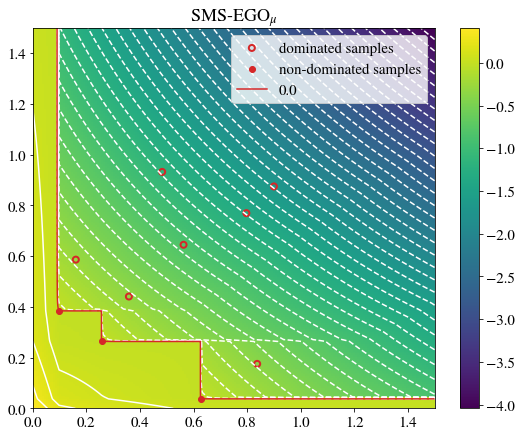

In [15]:
from testsuite.optimisers import SmsEgoMu

smsego_mu_opt = SmsEgoMu(objective_function=lambda x: x[0:2], limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=MultiSurrogate(GP), n_initial=10, seed=seed)
smsego_mu_opt.obj_weights = np.ones_like(smsego_mu_opt.obj_weights)
smsego_mu_opt.obj_offset = np.zeros_like(smsego_mu_opt.obj_offset)

fig_smsego_mu = image_infill(smsego_mu_opt, n_contours=40, uncertainty=0.)
fig_smsego_mu.axes[0].set_title("SMS-EGO$_\mu$") 

In [12]:
# save_fig(fig_smsego_ei, name="objective_space_SMS_ei")

 <ipython-input-3-5d45382aaf80>:21: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


[1.88365878 2.87669527]
[0.09767591 0.03821028]


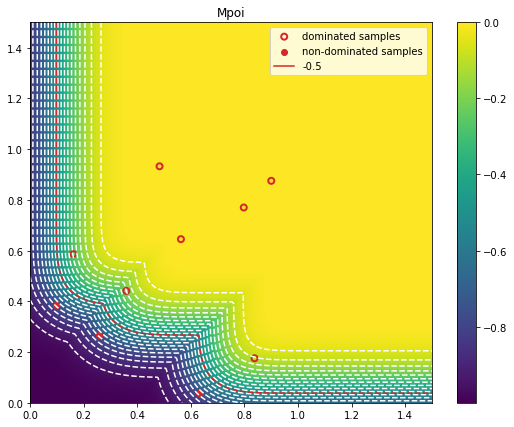

In [8]:
from testsuite.optimisers import Mpoi 

mpoi_opt = Mpoi(objective_function=lambda x: x[0:2],  limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=MultiSurrogate(GP), n_initial=10, seed=seed)
# mpoi_opt.obj_weights = np.ones_like(mpoi_opt.obj_weights)
# mpoi_opt.obj_offset = np.zeros_like(mpoi_opt.obj_offset)


front_v = -0.5 if INVERT else 0.5
fig_mpoi = image_infill(mpoi_opt, front_value=front_v)
fig_mpoi.axes[0].set_title("Mpoi") 
print(mpoi_opt.obj_weights)
print(mpoi_opt.obj_offset)

 <ipython-input-3-5d45382aaf80>:21: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0.5, 1.0, 'sms-ego | saf')

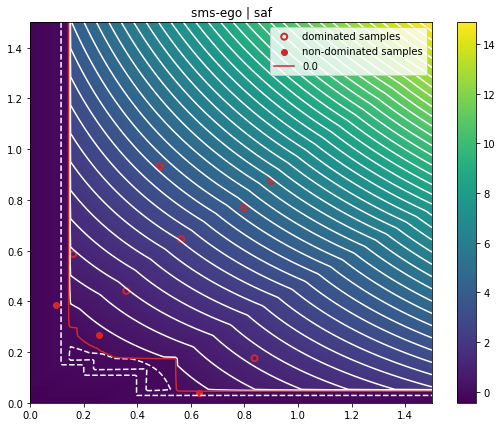

In [9]:
from testsuite.optimisers import Saf_Sms

safsms_opt = Saf_Sms(objective_function=lambda x: x[0:2], ei=True,  limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=MultiSurrogate(GP), n_initial=10, seed=seed)
fig_safsms = image_infill(safsms_opt, n_contours=40)
fig_safsms.axes[0].set_title("sms-ego | saf") 

 <ipython-input-3-5d45382aaf80>:21: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0.5, 1.0, 'sms-ego | saf')

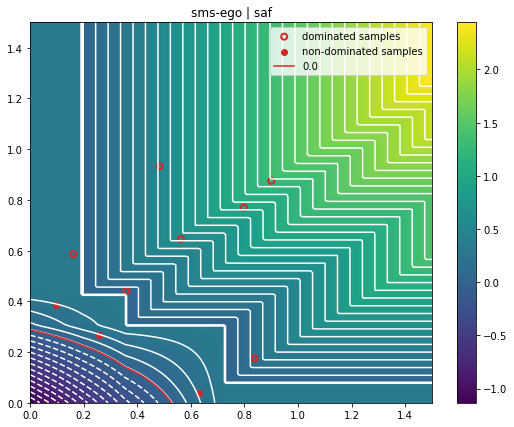

In [10]:
from testsuite.optimisers import Sms_Saf

smssaf_opt = Sms_Saf(objective_function=lambda x: x[0:2], ei=False,  limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=MultiSurrogate(GP), n_initial=10, seed=seed)
fig_smssaf = image_infill(smssaf_opt, n_contours=40)
fig_smssaf.axes[0].set_title("sms-ego | saf") 

 <ipython-input-3-5d45382aaf80>:21: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0.5, 1.0, 'saf ei | saf $\\mu$')

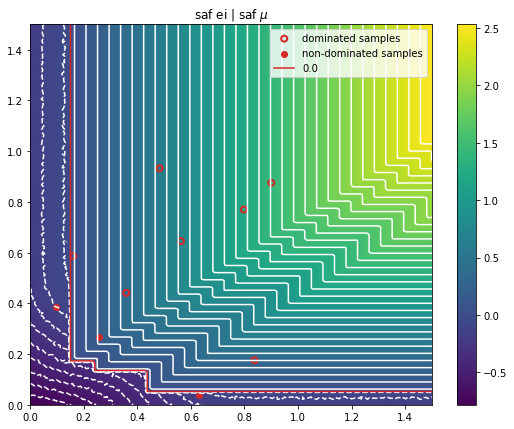

In [11]:
from testsuite.optimisers import Saf_Saf

safsaf_opt = Saf_Saf(objective_function=lambda x: x[0:2], ei=True,  limits=[[0, 0, 0, 0, 0], [1,1,1,1,1]], surrogate=MultiSurrogate(GP), n_initial=10, seed=seed)
fig_safsaf = image_infill(safsaf_opt, n_contours=40)
fig_safsaf.axes[0].set_title("saf ei | saf $\mu$")

In [12]:
sys.path.append("/home/finley/phd/code/gecco-2017/IscaOpt")

In [13]:
from multi_surrogate import SMSEGO as alma_ego
from multi_surrogate import MPoI as alma_mpoi

In [14]:
sms = alma_ego(func= lambda x: x[0:2], n_dim=5, n_obj=2, lower_bounds=[0,0], upper_bounds=[10,10], Y=smsego_opt.y, ref_vector=[2., 2.])
yt, comp_mat = sms.get_dom_matrix(smsego_opt.y)
sms.pfr_inds = sms.get_front(smsego_opt.x, comp_mat)
sms.ytr = sms.Y
sms.current_hv = sms.current_hpv()
sms.epsilon =np.array([1., 1.]) 

pfr_inds = sms.get_front(sms.ytr, comp_mat)
current_hv = sms.current_hpv()
n_pfr = len(sms.pfr_inds)
c = 1 - (1/ 2**sms.n_obj)
sms.b_count = 22 
sms.epsilon = (np.max(sms.ytr, axis=0) - np.min(sms.ytr, axis=0))\
                /(n_pfr + (c * sms.b_count))
sms.ref_vector = smsego_ei_opt.ref_vector
print(sms.ref_vector)

[1.2 1.2]


In [15]:
sms._scalarise_y = lambda *args, **kwargs:-sms.scalarise_y(*args, **kwargs)[0]

 <ipython-input-16-55bcb1927f1c>:20: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


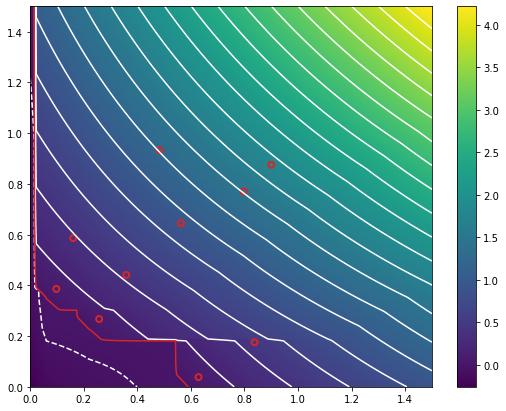

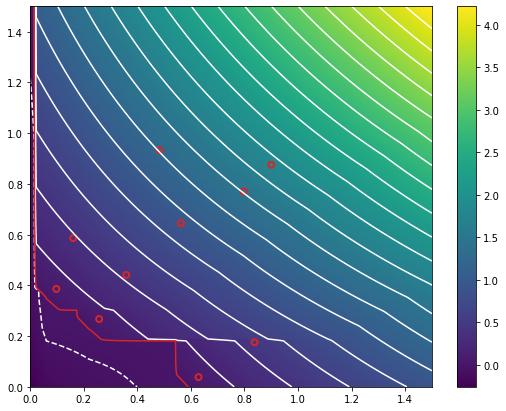

In [16]:
#figure_properties
fig = plt.figure(figsize=[9,7])
ax = fig.gca()
ax.set_xlim([0,1.5])
ax.set_ylim([0,1.5])

# compute infill
M, N = 200, 200
x = np.linspace(0, 1.5, M)
y = np.linspace(0, 1.5, N)
xx, yy = np.meshgrid(x, y)
xy = np.vstack((xx.flat, yy.flat)).T

zz = np.array([sms._scalarise_y(np.array(xy[i:i+1]), np.array([uncertainty,uncertainty]), True) for i in range(len(xy))])
zz = zz.reshape(N,M)

n_contours=20
front_value=0.
#image infill
pcol = ax.pcolor(xx, yy, zz)
levels = np.linspace(zz.min(), zz.max(), n_contours+2)[1:-1]
ax.contour(xx, yy, zz, colors="white", levels=levels)
if front_value is not None:
    ax.contour(xx, yy, zz, colors="C3", levels=[front_value])
    front_legend = plt.Line2D([0], [0], c="C3")

# scatter samples
ax.scatter(sms.Y[:,0], sms.Y[:,1], facecolors='none', edgecolors="C3", linewidth=2., label="dominated samples")
fig.colorbar(pcol)
fig

In [17]:
sms.ref_vector

array([1.2, 1.2])

In [18]:
mpoi = alma_mpoi(func= lambda x: x[0:2], n_dim=5, n_obj=2, lower_bounds=[0,0], upper_bounds=[10,10], Y=smsego_opt.y, ref_vector=[2., 2.])

 <ipython-input-19-72232418de29>:24: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
 <ipython-input-19-72232418de29>:28: UserWarning:No contour levels were found within the data range.


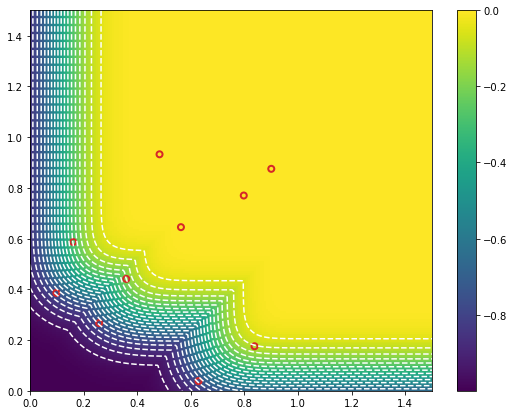

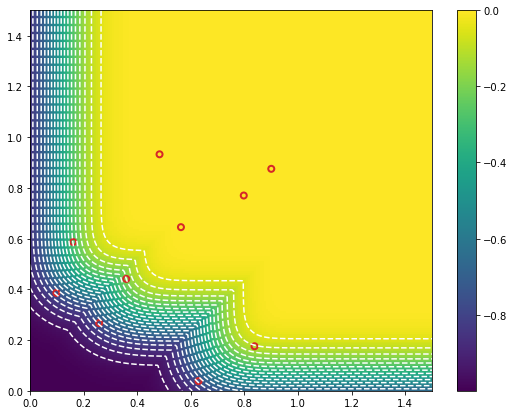

In [19]:
from scipy.special import erf as ERF 
from scipy.stats import norm as NORM

def f_mpoi(yp, stdp):
#     print(yp.shape)
#     print(stdp.shape)
    y = Pareto_split(sms.Y)[0]
    res = np.zeros((yp.shape[0], 1))
    sqrt2 = np.sqrt(2)
    for i in range(yp.shape[0]):
        m = (yp[i] - y)/(sqrt2 * stdp[i])
        pdom = 1 - np.prod(0.5 * (1 + ERF(m)), axis=1)
        res[i] = np.min(pdom)
    return -res
        
fig = plt.figure(figsize=[9,7])
ax = fig.gca()
ax.set_xlim([0,1.5])
ax.set_ylim([0,1.5])

zz = np.array([f_mpoi(np.array(xy[i:i+1]), np.array([[uncertainty,uncertainty]])) for i in range(len(xy))])
zz = zz.reshape(N,M)

pcol = ax.pcolor(xx, yy, zz)
levels = np.linspace(zz.min(), zz.max(), n_contours+2)[1:-1]
ax.contour(xx, yy, zz, colors="white", levels=levels)
if front_value is not None:
    ax.contour(xx, yy, zz, colors="C3", levels=[0.5])
    front_legend = plt.Line2D([0], [0], c="C3")

# scatter samples
ax.scatter(sms.Y[:,0], sms.Y[:,1], facecolors='none', edgecolors="C3", linewidth=2., label="dominated samples")
fig.colorbar(pcol)
fig